# Record Linkage 

---

## Introduction

When you combine information about from multiple sources, you have to determine whether two individuals in two separate datasets are the same. You also might have multiple individuals with the same name in one dataset and need to decide whether to treat them as the same person or not. This has important implications for your analysis. Record linkage also goes by the terms data matching, merge/purge, duplication detection, de-duping, reference matching, co-reference/anaphora in various fields. 

There are several approaches to record linkage that include **exact matching** (for example, joining records based on social security number), **rule-based linking** (applying a hierarchical set of rules that reflect domain knowledge; for example, if two people have the same first and last name and the same birthday they are considered the same); and **probabilistic linking**, or estimating the likelihood that two entities are the same and then deciding on a threshold above which two individuals will be considered to be the same. 

This tutorial will cover preprocessing data, rule-based linkage and probabilitic linkage using the Felligi-Sunter model. It was adapted from the [Big Data and Social Science Data Linkage tutorial](https://github.com/CSSIP-AIR/Big-Data-Workbooks/blob/master/08.%20Data%20Linkage/Record%20Linkage.ipynb). 



## Table of Contents
1. [Load the Data](#Load-the-Data)
2. [Explore the Data](#Data-Exploration)
3. [Preprocess the Data](#Preprocess:-clean-Up-Names-and-separate-to-first-middle-and-last-name)
4. [Explore Metrics](#String-Comparators)
5. [Rule-Based Linkage](#rule-based-linkage)
6. [Probabilistic Linkage](#probabilistic-linkage)

## Setup

In [1]:
%pylab inline
from __future__ import print_function
from six.moves import zip, range
import pandas as pd
import jellyfish
from collections import OrderedDict

Populating the interactive namespace from numpy and matplotlib


## Load the Data 
----

We'll look at grant funding using UC employee data and NSF award data. Given the name of an NSF award, we want to find the job title and employee ID. Our first dataset is all NSF grants awarded between 2010-2012. 

Given the name of an award match their record with the UC database to get their position and employee id. 

In [2]:
# Read in NSF awards data
df_nsf_awards = pd.read_csv('./data/nsf_awards_2010-2012.csv')

In [3]:
# Take a first look at the data
df_nsf_awards.head()

,AwardId,FirstName,LastName,StartDate,EndDate,AwardTitle,AwardEffectiveDate,AwardExpirationDate,Name,CityName,ZipCode,PhoneNumber,StreetAddress,CountryName,StateName,StateCode
0,415302,Jeffrey,Kuhn,2010-01-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
1,415302,Robert,Rosner,2010-01-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
2,415302,Philip,Goode,2010-01-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
3,415302,Thomas,Rimmele,2012-03-15,NaN,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC
4,415302,Stephen,Keil,2010-01-15,2012-03-15,Advanced Technology Solar Telescope (ATST) Con...,2010-01-01,2015-09-30,Association of Universities for Research in As...,Washington,20005-3929,2.024832e+09,"1212 New York Avenue, N.W.,",United States,District of Columbia,DC


Our second dataset is a list of all employees in the UC System in 2011. 

In [4]:
# Read in UC data
df_ucpay = pd.read_csv('./data/ucpay2011.csv', sep='\t')

In [5]:
# Look at what the UC data contains
df_ucpay.head()

,ID,year,campus,name,title,gross,base,overtime,extra,exclude
0,1751971,2011,BERKELEY,***********,TUTOR - NON-GSHIP,0.49,0.0,0.0,0,0
1,1758984,2011,BERKELEY,***********,TUTOR - NON-GSHIP,0.49,0.0,0.0,0,0
2,1821585,2011,IRVINE,***********,TUTOR - NON-GSHIP,0.51,0.0,0.0,0,0
3,1966846,2011,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III,0.62,0.0,0.0,0,0
4,1758947,2011,BERKELEY,***********,READER - NON-GSHIP,0.73,0.0,0.0,0,0


We can see there are some redacted names - some entries just have `********` in the `name` column. How might this affect our analysis? Let's do some data exploration to find out. 

## Data Exploration
----

Looking at the first 5 rows of the UC data above, we only see 2011 in the `year` column. Let's double check and see if there are any other years contained in this dataset. Looking at all the *unique* values of a column tells us about all the possible values that column can take on, and is a helpful starting point in exploring the dataset.

In [6]:
# Get all unique entries in the 'year' column
df_ucpay.year.unique()

array([2011], dtype=int64)

Looks like we were right about the `year` - the UC dataset only covers 2011. How about the `campus` column?

In [7]:
# Get all unique entries in the 'campus' column
df_ucpay.campus.unique()

array(['BERKELEY', 'IRVINE', 'SAN FRANCISCO', 'LOS ANGELES', 'DANR',
       'SANTA BARBARA', 'SANTA CRUZ', 'RIVERSIDE', 'DAVIS', 'MERCED',
       'SAN DIEGO', 'UCOP'], dtype=object)

Looks like we have a few UC campuses that we recognize, plus `DANR` and `UCOP`. How many records do we have for each campus? We'll do a `groupby` to find out, and plot it so we can visualize the makeup of the dataset.

<AxesSubplot:ylabel='campus'>

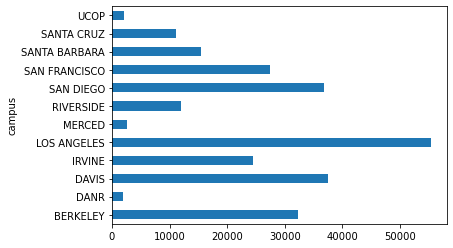

In [8]:
# Look at number of entries by campus in the dataset
df_ucpay.groupby('campus').size().plot(kind='barh')

In [9]:
# Get all unique titles
df_ucpay.title.unique()

array(['TUTOR - NON-GSHIP', 'STAFF RESEARCH ASSOC III',
       'READER - NON-GSHIP', ..., 'ATHLETICS MANAGER 4',
       'CHIEF EXEC OFFICER - MED CENTR', 'TREASURER OF THE REGENTS'],
      dtype=object)

In [10]:
# Find out how many unique titles are present in the data
len(df_ucpay.title.unique())

2626

We can see that there are 2626 unique positions in the system, but we'd expect that people getting grants from NSF are probably a very limited fraction of those. Most likely, NSF grants would go to people whose titles are along the lines of "Professor," "Postdoctoral Researcher," or "Research Professional" - it's unlikely that "Athletics Manager 4" is applying for or receiving too much NSF funding. 

In [11]:
# Get number of rows and columns of UC dataset
df_ucpay.shape

(259043, 10)

We can only match individuals in the UC data to individuals in the NSF data if we know their names. That means that we'll have to remove all of those redeacted names from the UC dataset - they won't be useful in our analysis. 

*Note: Whenever you remove observations from your data, think about if the missingness or redaction is informative. Which people are more likely to have their names redacted? Is that related to our outcome of interest?*

In [12]:
# Use a mask to keep only entries that do NOT have stars instead of a name
mask = df_ucpay.name != "***********" 

# Look at size of this mask
df_ucpay[mask].shape

(163429, 10)

We see that the number of rows of the mask is 163,429, as opposed to 259,043 in the original UC dataset. This means that about 100,000 rows were missing names. 

In [13]:
# Save df_ucpay with only named entries
df_ucpay = df_ucpay[mask]

In [14]:
# Look at the first 15 entries in the updated dataset with redacted names removed
df_ucpay.head(15)

,ID,year,campus,name,title,gross,base,overtime,extra,exclude
3,1966846,2011,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III,0.62,0.00,0.0,0,0
6,1870390,2011,LOS ANGELES,"ESCUJURI , ERIC JOSEPH","TECHNICIAN, SCENE, SR",1.14,0.00,0.0,0,0
7,1771936,2011,BERKELEY,"JUNG , WOO YONG",POSTDOC-EMPLOYEE,1.28,1.28,0.0,0,0
8,1892122,2011,LOS ANGELES,"SHAPIRO , JORDAN ISAAC","TECHNICIAN, SCENE",1.33,0.00,0.0,0,0
12,1988359,2011,SANTA BARBARA,"CUTLER , CHARLES IAN",LABORATORY ASST I,1.55,0.00,0.0,0,0
15,1861869,2011,LOS ANGELES,"ANDERSON , MARK CALVIN","TECHNICIAN, SCENE, SR",1.83,0.00,0.0,0,0
25,1887191,2011,LOS ANGELES,"PATEL , DEV KAPIL",ASSISTANT IV,2.19,2.19,0.0,0,0
26,1875426,2011,LOS ANGELES,"HILDER , JAMIE L",POSTDOC-EMPLOYEE,2.20,2.20,0.0,0,0
46,1977209,2011,SAN FRANCISCO,"WU , YALEI",POSTDOC-EMPLOYEE,2.84,2.84,0.0,0,0
73,1895865,2011,LOS ANGELES,"VALERIO , STEVEN GERARD,JR","TECHNICIAN, SCENE",4.24,0.00,0.0,0,0


Looks like that worked - now we've filtered out all the redacted names. 

For the purposes of our analysis, we only want to know a researcher's name, job title, and the campus where they work. Let's toss the other columns so we have something more manageable to work with. 

In [15]:
# List of columns to keep 
selected_columns = ['ID','campus', 'name', 'title']

# Subset data frame to only include those columns
df_ucpay = df_ucpay[selected_columns]

In [16]:
# Look at the updated dataframe
df_ucpay.head()

,ID,campus,name,title
3,1966846,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III
6,1870390,LOS ANGELES,"ESCUJURI , ERIC JOSEPH","TECHNICIAN, SCENE, SR"
7,1771936,BERKELEY,"JUNG , WOO YONG",POSTDOC-EMPLOYEE
8,1892122,LOS ANGELES,"SHAPIRO , JORDAN ISAAC","TECHNICIAN, SCENE"
12,1988359,SANTA BARBARA,"CUTLER , CHARLES IAN",LABORATORY ASST I


Since we're combining the NSF data with University of *California* data, we really only care about the awards in the dataset that went to people in California. Let's filter the NSF data to only contain entries with `StateCode` 'CA'. 

In [17]:
state_mask = df_nsf_awards['StateCode'] == 'CA'
df_nsf_awards = df_nsf_awards[state_mask]

In [18]:
df_nsf_awards.head()

,AwardId,FirstName,LastName,StartDate,EndDate,AwardTitle,AwardEffectiveDate,AwardExpirationDate,Name,CityName,ZipCode,PhoneNumber,StreetAddress,CountryName,StateName,StateCode
17,805989,Albert,Schwarz,2010-08-26,NaN,Application of methods of arithmetic geometry ...,2010-09-01,2014-08-31,University of California-Davis,Davis,95618-0000,5.307548e+09,OR/Sponsored Programs,United States,California,CA
40,820047,Frans,Tax,2011-03-28,NaN,Arabidopsis 2010: Global Analysis of Translati...,2009-03-01,2013-02-28,University of California-Riverside,RIVERSIDE,92521-1000,9.518276e+09,Office of Research,United States,California,CA
49,825254,Paul,Davis,2012-01-27,NaN,Collaborative Research: A 3D Seismic Study of ...,2010-01-01,2013-09-30,University of California-Los Angeles,LOS ANGELES,90095-2000,3.107940e+09,"11000 Kinross Avenue, Suite 211",United States,California,CA
53,830228,Nicholas,Melosh,2011-08-06,NaN,NSEC: CENTER FOR PROBING THE NANOSCALE,2009-09-01,2014-08-31,Stanford University,Palo Alto,94304-1212,6.507232e+09,3160 Porter Drive,United States,California,CA
58,831132,Joseph,Pasquale,2010-04-12,NaN,Collaborative Research; CT-M: Computer Systems...,2009-03-01,2012-12-31,University of California-San Diego,La Jolla,92093-0934,8.585345e+09,Office of Contract & Grant Admin,United States,California,CA


Great! Now we have what we need to do our analysis, and not a whole lot of extraneous information. Let's move on to preprocessing.

<a id='Preprocess:-clean-Up-Names-and-separate-to-first-middle-and-last-name'></a>
## Preprocessing the Data
-----

Now we want to connect the NSF and UC data. To do this, we need to figure out which people are the same in both datasets. We need to clean up names and make sure they're in the same format. 

First let's take a look at the names in the UC dataset.

In [19]:
# Get all of the values in the "name" column in the df_ucpay dataframe 
names_ucpay = df_ucpay.name.values
print(names_ucpay)

['MACKEWICZ , CARL E' 'ESCUJURI , ERIC JOSEPH' 'JUNG , WOO YONG' ...
 'BUSUTTIL , RONALD W' 'HOWLAND , BENJAMIN CLARK' 'TEDFORD , JEFF']


We see that the `name` field in the UC data is structured as *LASTNAME* , *FIRSTNAME* *MIDDLE*, where *MIDDLE* can be a middle initial or a full middle name. 

In [20]:
# Get all of the values in the "FirstName" column in the df_nsf_awards dataframe
firstnames_nsf_awards = df_nsf_awards.FirstName.values
print(firstnames_nsf_awards)

['Albert' 'Frans' 'Paul' ... 'Wenguang' 'Laurent' 'Benjamin']


In [21]:
# Get all of the values in the "LastName" column in the df_nsf_awards dataframe
lastnames_nsf_awards = df_nsf_awards.LastName.values
print(lastnames_nsf_awards)

['Schwarz' 'Tax' 'Davis' ... 'Sun' 'El Ghaoui' 'Lev']


The NSF names are formatted differently - we have two separate fields for first and last name, and unlike the UC names (which were all capitalized), these names have the first letter capitalized, and the rest lower case. To be able to directly compare them, we'll have to make them match each other - let's make all the letters lower case, and split the UC names (which are one field) into two fields: first and last name. 

Remember the rule we noticed about the UC names - they always have the last name, followed by a comma, followed by the first name. If we split each name into two fields at the comma, then the first field will be the last name, and the second field will be the first name (and any middle names). 

In [22]:
# Take the first name from the UC dataset
test_name = names_ucpay[0]

# Make UC names lower case 
test_name = test_name.lower()

# Split UC names on comma
test_name = test_name.split(',')

print(test_name)

['mackewicz ', ' carl e']


That worked! OK, now let's combine all of that into a **function** so we can do this efficiently for *all* of the names in the UC data set.

In [25]:
def split_names(name):
    """
    Splits names fields into first, middle and last names
    and return lower case values. 
    
    Parameters
    -----------
    name: str
        e.g. SHAPIRO, JORDAN ISAAC
    
    Returns
    -------
    (first, middle, last): str
        e.g. (jordan, isaac, shapiro)
    """
    
    # make the name lower case
    name=name.lower()
    
    # split the name into two fields at the comma
    ls_name = name.split(',')

    # Since the last name came first, we save the first entry as the last name
    # and second entry as the first name
    last_name = ls_name[0]
    first_middle_name = ls_name[1]
    
    #split by space to get the first and middle name
    ls_first_middle_name = first_middle_name.split()
    if len(ls_first_middle_name) > 1:
        first_name = ls_first_middle_name[0]
        middle_name = ls_first_middle_name[1]
    else: 
        first_name = ls_first_middle_name[0]
        middle_name = ''
    return first_name.strip(), middle_name.strip(), last_name.strip()

Notice in the function above we're taking for granted that a first name can only be one word - we assume that any space means that the following word is the middle name. Of course, there could be someone whose first name contains a space, but we are using the best rule of thumb that we have for this dataset.

In [26]:
# Apply our function to all the names in the UC dataset
ls_cleaned_names = [split_names(name) for name in names_ucpay]

OK, now we have this huge list of names - that's a little bit unwieldy. What we really want is one list of first names, one list of middle names, and one list of last names (and for them to be in the correct order). Luckily, it's easy to do that in Python:

In [27]:
ls_first, ls_middle, ls_last = zip(*ls_cleaned_names)

In [28]:
# Put colums in the UC dataset for first, middle, and last name
df_ucpay['first'] = ls_first
df_ucpay['middle'] = ls_middle
df_ucpay['last'] = ls_last

In [29]:
df_ucpay.head()

,ID,campus,name,title,first,middle,last
3,1966846,SAN FRANCISCO,"MACKEWICZ , CARL E",STAFF RESEARCH ASSOC III,carl,e,mackewicz
6,1870390,LOS ANGELES,"ESCUJURI , ERIC JOSEPH","TECHNICIAN, SCENE, SR",eric,joseph,escujuri
7,1771936,BERKELEY,"JUNG , WOO YONG",POSTDOC-EMPLOYEE,woo,yong,jung
8,1892122,LOS ANGELES,"SHAPIRO , JORDAN ISAAC","TECHNICIAN, SCENE",jordan,isaac,shapiro
12,1988359,SANTA BARBARA,"CUTLER , CHARLES IAN",LABORATORY ASST I,charles,ian,cutler


Now back to the NSF data - remember, that dataset had one field for first name, and one field for last name. If we don't have a first name or don't have a last name for anyone, we're not going to be able to identify that person across the two datasets. Let's remove, or "drop," all of the entries in `df_nsf_awards` that have **NA**s, or missing values, for the `FirstName` or `LastName` field.

The `inplace=True` option means that we'll just drop the NAs from the existing `df_nsf_awards` dataframe - we don't want to save a copy with NAs for anything.

In [30]:
df_nsf_awards.dropna(subset=['FirstName','LastName'], inplace=True)

Now let's make all of the names lower case, so the format of these names matches the format of the UC names.

In [33]:
df_nsf_awards['first'] = [name.lower() for name in df_nsf_awards['FirstName'].values]
df_nsf_awards['last'] = [name.lower() for name in df_nsf_awards['LastName'].values]

*Include a link to some documentation about  encoding*
>**Note**: In python2 we have to explicitly tell Python we want a string to be encoding in unicode. In Python3 all strings 
>are by default unicode. 


In [34]:
df_nsf_awards.head()

,AwardId,FirstName,LastName,StartDate,EndDate,AwardTitle,AwardEffectiveDate,AwardExpirationDate,Name,CityName,ZipCode,PhoneNumber,StreetAddress,CountryName,StateName,StateCode,first,last
17,805989,Albert,Schwarz,2010-08-26,NaN,Application of methods of arithmetic geometry ...,2010-09-01,2014-08-31,University of California-Davis,Davis,95618-0000,5.307548e+09,OR/Sponsored Programs,United States,California,CA,albert,schwarz
40,820047,Frans,Tax,2011-03-28,NaN,Arabidopsis 2010: Global Analysis of Translati...,2009-03-01,2013-02-28,University of California-Riverside,RIVERSIDE,92521-1000,9.518276e+09,Office of Research,United States,California,CA,frans,tax
49,825254,Paul,Davis,2012-01-27,NaN,Collaborative Research: A 3D Seismic Study of ...,2010-01-01,2013-09-30,University of California-Los Angeles,LOS ANGELES,90095-2000,3.107940e+09,"11000 Kinross Avenue, Suite 211",United States,California,CA,paul,davis
53,830228,Nicholas,Melosh,2011-08-06,NaN,NSEC: CENTER FOR PROBING THE NANOSCALE,2009-09-01,2014-08-31,Stanford University,Palo Alto,94304-1212,6.507232e+09,3160 Porter Drive,United States,California,CA,nicholas,melosh
58,831132,Joseph,Pasquale,2010-04-12,NaN,Collaborative Research; CT-M: Computer Systems...,2009-03-01,2012-12-31,University of California-San Diego,La Jolla,92093-0934,8.585345e+09,Office of Contract & Grant Admin,United States,California,CA,joseph,pasquale


# String Comparators

Now that we have clean first and last names for every entry in each dataset, let's explore how we actually match the string fields. It's easy to see how we'd compare numerical fields - if we wanted to compare grant awards, we might subtract one dollar amount from another to see the monetary difference, or look at the number of days between two dates to see how close they were in time.  

Comparing text fields, or strings, is a little bit trickier. It's easy to say if two words are *exactly* the same: if they have all of the same letters, in the same order, they're the same word. But how do you quantify how *far away* two words are from each other? One metric is the **edit distance**, or the minimum number of edits it would take to transform one word into the other. The number of insertions (adding a letter), deletions (removing a letter) and substitutions (swapping one letter for another) to transform one string to another is known as the *Levenshtein distance* between the two words. The *Levenshtein-Damerau distance* builds on the Levenshtein distance by including one more step, or transposing two adjacent letters. 

The *Jaro-Winkler* distance is a fast-to-compute distance metric that returns a normalized score between zero and one: one indicates the words match exactly, and zero indicates no similarity between the two words.  

In [35]:
class StringComparators():
    """
    Test various string comparators 
    """

    def test_levenshtein_distance():
        assert jellyfish.levenshtein_distance('John', 'John') == 0
        assert jellyfish.levenshtein_distance('Jon', "John") == 2
        assert jellyfish.levenshtein_distance('Joseph', 'Joesph') == 1
        
    def test_damerau_levenshtein():
        assert jellyfish.damerau_levenshtein_distance('Joseph', 'Joesph') == 1

    def test_jaro_winklear():
        assert (np.isclose(jellyfish.jaro_winkler('Joseph', 'Joesph'), 0.955555))
        assert (np.isclose(jellyfish.jaro_winkler('Chris', 'Christoper'), 0.9))

Let's compare all of the first names in the UC dataset with all of the first names in the NSF dataset.

In [36]:
# Get all of the unique names from NSF and UC 
nsf_firstnames = set( df_nsf_awards['first'].values ) 

# grab the uc_names
uc_firstnames = df_ucpay['first'].values 

In [37]:
# Comparison of records
testname = uc_firstnames[0]

In [38]:
# we should document this better and uc_names an argument
def get_matching_first_name(testname, NUM_NAMES=10):
    """
    get top 10 first names that match
    """
    dict_name_pair = {}
    for name in uc_firstnames:
        name = name
        dist = jellyfish.jaro_winkler(testname,name)
        dict_name_pair[name] = dist

    orddict_dict_name_pair = OrderedDict(
                                sorted(dict_name_pair.items(), key=lambda x: x[1]))

    ls_sorted_name = list(orddict_dict_name_pair.keys())


    return ls_sorted_name[-NUM_NAMES:][::-1]

In [39]:
print(testname, get_matching_first_name(testname))

carl ['carl', 'carlo', 'carli', 'carly', 'carla', 'caryl', 'carol', 'carlet', 'carlee', 'carlen']


In [40]:
for nm in uc_firstnames[:25]:
    testname = nm
    print(testname, get_matching_first_name(testname))

carl ['carl', 'carlo', 'carli', 'carly', 'carla', 'caryl', 'carol', 'carlet', 'carlee', 'carlen']
eric ['eric', 'erice', 'erich', 'erick', 'erica', 'erric', 'eri', 'edric', 'enric', 'ericia']
woo ['woo', 'wood', 'wook', 'woon', 'wo', 'woori', 'woody', 'woojong', 'woodrow', 'woodward']
jordan ['jordan', 'jordane', 'jordana', 'jourdan', 'jordin', 'jordon', 'jordaniel', 'jodean', 'joan', 'joraine']
charles ['charles', 'charless', 'charese', 'charley', 'charlee', 'charlie', 'charleston', 'charline', 'charlane', 'charleen']
mark ['mark', 'marko', 'marka', 'marek', 'mar', 'markle', 'markim', 'markos', 'markee', 'markus']
dev ['dev', 'deva', 'devi', 'de', 'devie', 'devra', 'devan', 'devyn', 'devon', 'devin']
jamie ['jamie', 'jamiel', 'jammie', 'jami', 'jaymie', 'jaime', 'jamaine', 'amie', 'jazmine', 'jasmine']
yalei ['yalei', 'yale', 'yanlei', 'yali', 'yaneli', 'yafei', 'yawei', 'yanli', 'yael', 'maylei']
steven ['steven', 'steaven', 'steve', 'stevie', 'stevon', 'stevan', 'sten', 'steven-huy'

<a id='#rule-based-linkage'></a>
## Rule-Based Matching 

Let's try to merge data with the following rules. 

1. The first name Jaro-Winkler score has to be greater than 0.90
2. The last name Jaro-Winkler score has to be greater then 0.90

This rule essentially means that the names have to match with very minor typos. 


In [42]:
dict_nsf_awards = df_nsf_awards[:10].to_dict(orient='index')
dict_nsf_awards

{17: {'AwardId': 805989,
  'FirstName': 'Albert',
  'LastName': 'Schwarz',
  'StartDate': '2010-08-26',
  'EndDate': nan,
  'AwardTitle': 'Application of methods of arithmetic geometry and homological algebra to quantum field theory and string theory',
  'AwardEffectiveDate': '2010-09-01',
  'AwardExpirationDate': '2014-08-31',
  'Name': 'University of California-Davis',
  'CityName': 'Davis',
  'ZipCode': '95618-0000',
  'PhoneNumber': 5307547700.0,
  'StreetAddress': 'OR/Sponsored Programs',
  'CountryName': 'United States',
  'StateName': 'California',
  'StateCode': 'CA',
  'first': 'albert',
  'last': 'schwarz'},
 40: {'AwardId': 820047,
  'FirstName': 'Frans',
  'LastName': 'Tax',
  'StartDate': '2011-03-28',
  'EndDate': nan,
  'AwardTitle': 'Arabidopsis 2010: Global Analysis of Translational Regulons',
  'AwardEffectiveDate': '2009-03-01',
  'AwardExpirationDate': '2013-02-28',
  'Name': 'University of California-Riverside',
  'CityName': 'RIVERSIDE',
  'ZipCode': '92521-1000',

In [43]:
def create_rule_mask(nsf_first_name, 
                     nsf_last_name,
                     df_ucpay,
                     first_name_thresh=0.90,
                     last_name_thresh=0.90):
    """
    Returns a boolean array of records to match based on a
    fixed threshold. 
    
    Parameters
    ----------
    (nsf_first_name, nsf_last_name): str
        first and last name in the NSF dataset
        
    df_ucpay: DataFrame
        DataFrame of the UC directory
        
    (first_name_thresh,last_name_thresh): int
        
        
    Returns
    -------
    jaro_mask: ls[bool]
        boolean list of records to match
    """
    compare_first = lambda x: jellyfish.jaro_winkler(nsf_first_name,x)
    compare_last = lambda x: jellyfish.jaro_winkler(nsf_last_name,x)

    jaro_first = df_ucpay['first'].map(compare_first) 
    jaro_last = df_ucpay['last'].map(compare_last)

    jaro_mask = (jaro_first > first_name_thresh) & (jaro_last > last_name_thresh)
    
    return jaro_mask
    

In [44]:
def match_records(dict_nsf_awards, df_ucpay, f_create_rule_mask):
    """
    match records from the nsf and uc datasets based on the fields 'first' and 'last' name
    
    Parameters
    ---------
    dict_nsf_awards: dict
        dictionary of nsf awards
    df_ucpay: DataFrame
        DataFrame of UC employees
    create_rule_mask: function
        Function that takes a first name, last name and df_ucpay
        and returns a Boolean array of whether or not to match 
        records
    
    Returns
    -------
    df_linked_data: DataFrame
    """
    
    df_linked_data = pd.DataFrame()
    for key in dict_nsf_awards.keys():
        dict_test_row = dict_nsf_awards[key]
    
        nsf_first_name = dict_test_row['first']
        nsf_last_name = dict_test_row['last']

        jaro_mask = f_create_rule_mask(nsf_first_name, nsf_last_name, df_ucpay)
    
        df_matches = df_ucpay[jaro_mask]
        if len(df_matches) == 0:
            print('No Match: {} {}'.format(nsf_first_name,nsf_last_name))
        for row in df_matches.iterrows():
            dict_test_row['ID'] = row[1]['ID']
            dict_test_row['campus'] = row[1]['campus']
            dict_test_row['name'] = row[1]['name']
            dict_test_row['title'] = row[1]['title']
            df_linked_data = df_linked_data.append(dict_test_row, ignore_index=True)
            
    return df_linked_data

In [45]:
df_linked_data = match_records(dict_nsf_awards, df_ucpay, create_rule_mask )

No Match: frans tax
No Match: nicholas melosh
No Match: craig heinselman
No Match: mary mccready


In [46]:
selected_columns = ['AwardId', 'CityName', 'FirstName', 'ID', 'LastName', 'Name', 'campus', 'title', 'first', 'last']
df_linked_data[selected_columns]

,AwardId,CityName,FirstName,ID,LastName,Name,campus,title,first,last
0,805989.0,Davis,Albert,1814365.0,Schwarz,University of California-Davis,DAVIS,PROFESSOR - ACADEMIC YEAR,albert,schwarz
1,825254.0,LOS ANGELES,Paul,1832316.0,Davis,University of California-Los Angeles,IRVINE,"ANALYST, ADMINISTRATIVE, ASST",paul,davis
2,825254.0,LOS ANGELES,Paul,1832352.0,Davis,University of California-Los Angeles,IRVINE,HOSPITAL UNIT SERV COORD II,paul,davis
3,825254.0,LOS ANGELES,Paul,1800777.0,Davis,University of California-Los Angeles,DAVIS,RESEARCH _____ - FISCAL YEAR,paul,davis
4,825254.0,LOS ANGELES,Paul,1868502.0,Davis,University of California-Los Angeles,LOS ANGELES,PROGRAMMER/ANALYST IV - SUPERV,paul,davis
5,825254.0,LOS ANGELES,Paul,1868593.0,Davis,University of California-Los Angeles,LOS ANGELES,PROFESSOR - ACADEMIC YEAR,paul,davis
6,831132.0,La Jolla,Joseph,1887173.0,Pasquale,University of California-San Diego,LOS ANGELES,"REPRESENTATIVE, ACCESS, PRIN",joseph,pasquale
7,831132.0,La Jolla,Joseph,1942864.0,Pasquale,University of California-San Diego,SAN DIEGO,PROFESSOR-ACAD YR-BUS/ECON/ENG,joseph,pasquale
8,832819.0,BERKELEY,Ronald,1768965.0,Fearing,University of California-Berkeley,BERKELEY,PROFESSOR-ACAD YR-BUS/ECON/ENG,ronald,fearing
9,833340.0,SANTA CRUZ,Gretchen,1999814.0,Andreasen,University of California-Santa Cruz,SANTA CRUZ,ADMIN/COORD/OFFICER(FUNC AREA),gretchen,andreasen


As we can see 4 records in the NSF database had no matches in the UC database. Also if we examine the output of the record linkage more closely we see we have a few false postives, Paul Davies, Joseph Pasquale.

There are several shortcomings to this approach:
    
1. There is no threshold that can be adjusted for the proper tolerance of false postives and false negatives
2. As you apply more and more rules is can become unclear what the combination of rules has on the final linkage
3. Rules also often reflect the creator's domain knowledge.

<a id='#probabilistic-linkage'></a>
## Probabilistic Record Linkage 
------

The final way is matching records *probabilistically*.  The **Fellegi-Sunter** model compares selected similiar fields in two records and calculates a similarity score, or a weighted probablity of the two records being the same entity.  

The algorithm is the following: two fields are first compared using a metric, in this case, the Jaro-Winkler distance (which can be between 0 and 1). The Jaro-Winkler distance is binned into one of three categories: exact match, close match, or no match. Each category has an associated distribution, based on known matches and unmatches. The log probability of being a match and the log probability of being a non-match are calculated for each pair. The final score is the log probablity of being a match minus the log probablity of being a non-match. If the final score is greater than a threshold, then the records are considered to match.

In [47]:
# We should probably just make these simple functions instead of objects
class FellegiSunter():
    """
    class to implement Fellegi Sunter model
    """
    
    m_weights = {'first_name': (0.01,0.14,0.85),
                 'last_name': (0.01,0.09,0.90)}
    
    u_weights = {'first_name': (0.88,0.10,0.02),
                 'last_name': (0.91,0.08,0.01)}
    
    
    def fuzzy_match(self,name1,name2):
        """
        Compares two strings using jaro-winker and
        outputs and returns one of three match
        levels.
        
        * exact match is a jaro-winkler score >= 0.92
        * close match is a jaro-winkler score > 0.85
        * no match is a jaro-winkler score < 0.85
        
        Parameters
        ----------
        (name1, name2): str
            two text strings to output
            
        Returns
        -------
        match_level: int
            one of three match levels
            2 - exact match 
            1 - close match
            0 - not a match
        """
        score = jellyfish.jaro_winkler(name1,name2)
        if score >= 0.92:
            return 2
        elif score > 0.85:
            return 1
        else:
            return 0
        
    def match_score(self,record1,record2):
        """
        computes the match score between a pair
        of records
        
        Parameters
        ----------
        (record1, record2): tuple(str)
            tuples of records to be compared
            
        Returns
        -------
        match_score: int
        
        Raises
        ------
        Exception
            tuples need to be the same size 
        """
        if not(len(record1) == len(record2)):
            raise Exception('records need to be same size')
        
        scores = [self.fuzzy_match(rec1,rec2) for rec1, rec2 in zip(record1, record2)]
        
        first_name_score, last_name_score = scores
        
        #grab the m and u weights
        
        first_name_m_weight = self.m_weights['first_name'][first_name_score]
        first_name_u_weight = self.u_weights['last_name'][first_name_score]
        
        last_name_m_weight = self.m_weights['first_name'][last_name_score]
        last_name_u_weight = self.u_weights['last_name'][last_name_score]
        
        log_prob_match = math.log(first_name_m_weight) + math.log(last_name_m_weight)
        log_prob_umatch = math.log(first_name_u_weight) + math.log(last_name_u_weight)
        
        match_score = log_prob_match - log_prob_umatch
        
        return match_score
        
    def link_record(self, record1, record2, threshold=0.5):
        """
        Returns True if records should be linked,
        False otherwise.
        
        Parameters
        ----------
        (record1, record2): tuple(str)
            tuples of records to be compared. must
            be the same length
        threshold: int
            threshold for linking or not
        
        Returns
        -------
        link: bool
            bool on whether to link two records or not
        """
        
        match_score = self.match_score(record1,record2)
        if match_score > threshold:
            return True
        else:
            return False
        

In [48]:
fs = FellegiSunter()

In [49]:
print( fs.link_record(('Avishek','Kumar'), ('Avishek','Kumar')) )

True


In [50]:
print( fs.link_record( ('Avishek','Kumar'), ('Anup','Kumar') ) )

False


In [51]:
#let's take this new function for a spin
print('jonathon', 'jonthon', fs.fuzzy_match('jonathon','jonthon') )
print('john', 'mark', fs.fuzzy_match('john','mark') )
print('fred', 'frederick', fs.fuzzy_match('fred', 'frederick'))

jonathon jonthon 2
john mark 0
fred frederick 1


In [52]:
def create_jaro_mask(nsf_first_name, nsf_last_name, df_ucpay):
    """
    create a boolean array for whether to link records based on
    the jaro-winkler distance
    
    Parameters
    ----------
    (nsf_first_name, nsf_last_name): str
        first and last name in the NSF dataset
        
    df_ucpay: DataFrame
        DataFrame of the UC directory
        
    Returns
    -------
    jaro_mask: ls[bool]
        boolean list of records to match
    """
    record = (nsf_first_name, nsf_last_name)
    uc_records = df_ucpay[['first','last']].values
    
    jaro_mask = [fs.link_record(record, uc_record) for uc_record in uc_records]
    
    return jaro_mask
    
    

In [53]:
df_linked_data = match_records(dict_nsf_awards, df_ucpay, create_jaro_mask )

No Match: frans tax
No Match: nicholas melosh
No Match: craig heinselman


In [54]:
sel_col = ['AwardId', 'CityName', 'FirstName', 'ID', 'LastName', 'Name', 'campus', 'title', 'first', 'last']
df_linked_data[sel_col]

,AwardId,CityName,FirstName,ID,LastName,Name,campus,title,first,last
0,805989.0,Davis,Albert,1814365.0,Schwarz,University of California-Davis,DAVIS,PROFESSOR - ACADEMIC YEAR,albert,schwarz
1,825254.0,LOS ANGELES,Paul,1832316.0,Davis,University of California-Los Angeles,IRVINE,"ANALYST, ADMINISTRATIVE, ASST",paul,davis
2,825254.0,LOS ANGELES,Paul,1832352.0,Davis,University of California-Los Angeles,IRVINE,HOSPITAL UNIT SERV COORD II,paul,davis
3,825254.0,LOS ANGELES,Paul,1800777.0,Davis,University of California-Los Angeles,DAVIS,RESEARCH _____ - FISCAL YEAR,paul,davis
4,825254.0,LOS ANGELES,Paul,1868502.0,Davis,University of California-Los Angeles,LOS ANGELES,PROGRAMMER/ANALYST IV - SUPERV,paul,davis
5,825254.0,LOS ANGELES,Paul,1868593.0,Davis,University of California-Los Angeles,LOS ANGELES,PROFESSOR - ACADEMIC YEAR,paul,davis
6,831132.0,La Jolla,Joseph,1887173.0,Pasquale,University of California-San Diego,LOS ANGELES,"REPRESENTATIVE, ACCESS, PRIN",joseph,pasquale
7,831132.0,La Jolla,Joseph,1942864.0,Pasquale,University of California-San Diego,SAN DIEGO,PROFESSOR-ACAD YR-BUS/ECON/ENG,joseph,pasquale
8,832819.0,BERKELEY,Ronald,1768965.0,Fearing,University of California-Berkeley,BERKELEY,PROFESSOR-ACAD YR-BUS/ECON/ENG,ronald,fearing
9,833340.0,SANTA CRUZ,Gretchen,1999814.0,Andreasen,University of California-Santa Cruz,SANTA CRUZ,ADMIN/COORD/OFFICER(FUNC AREA),gretchen,andreasen


Here is the matching using probablistic matching. We can change the thresholds do see how results will vary.

[Back to Table of Contents](#Table-of-Contents)